In [ ]:
# Install AgentChat and OpenAI client from Extensions
!pip install -U "autogen-agentchat" "autogen-ext[openai]"

In [13]:
!pip install rich

In [15]:
from google.colab import userdata
import openai
import os

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
openai.api_key  = os.environ["OPENAI_API_KEY"]

In [16]:
import json
import string
import uuid
from typing import List

import openai
from autogen_core import (
    DefaultTopicId,
    FunctionCall,
    Image,
    MessageContext,
    RoutedAgent,
    SingleThreadedAgentRuntime,
    TopicId,
    TypeSubscription,
    message_handler,
)
from autogen_core.models import (
    AssistantMessage,
    ChatCompletionClient,
    LLMMessage,
    SystemMessage,
    UserMessage,
)
from autogen_core.tools import FunctionTool
from autogen_ext.models.openai import OpenAIChatCompletionClient
from IPython.display import display  # type: ignore
from pydantic import BaseModel
from rich.console import Console
from rich.markdown import Markdown


Message Protocol

The message protocol for the group chat pattern is simple.

To start, user or an external agent publishes a GroupChatMessage message to the common topic of all participants.

The group chat manager selects the next speaker, sends out a RequestToSpeak message to that agent.

The agent publishes a GroupChatMessage message to the common topic upon receiving the RequestToSpeak message.

This process continues until a termination condition is reached at the group chat manager, which then stops issuing RequestToSpeak message, and the group chat ends.

In [17]:
class GroupChatMessage(BaseModel):
    body: UserMessage


class RequestToSpeak(BaseModel):
    pass


Base Group Chat Agent

In [18]:
class BaseGroupChatAgent(RoutedAgent):
    """A group chat participant using an LLM."""

    def __init__(
        self,
        description: str,
        group_chat_topic_type: str,
        model_client: ChatCompletionClient,
        system_message: str,
    ) -> None:
        super().__init__(description=description)
        self._group_chat_topic_type = group_chat_topic_type
        self._model_client = model_client
        self._system_message = SystemMessage(content=system_message)
        self._chat_history: List[LLMMessage] = []

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        self._chat_history.extend(
            [
                UserMessage(content=f"Transferred to {message.body.source}", source="system"),
                message.body,
            ]
        )

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:
        # print(f"\n{'-'*80}\n{self.id.type}:", flush=True)
        Console().print(Markdown(f"### {self.id.type}: "))
        self._chat_history.append(
            UserMessage(content=f"Transferred to {self.id.type}, adopt the persona immediately.", source="system")
        )
        completion = await self._model_client.create([self._system_message] + self._chat_history)
        assert isinstance(completion.content, str)
        self._chat_history.append(AssistantMessage(content=completion.content, source=self.id.type))
        Console().print(Markdown(completion.content))
        # print(completion.content, flush=True)
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=completion.content, source=self.id.type)),
            topic_id=DefaultTopicId(type=self._group_chat_topic_type),
        )


Writer and Editor Agents

In [19]:
class WriterAgent(BaseGroupChatAgent):
    def __init__(self, description: str, group_chat_topic_type: str, model_client: ChatCompletionClient) -> None:
        super().__init__(
            description=description,
            group_chat_topic_type=group_chat_topic_type,
            model_client=model_client,
            system_message="You are a Writer. You produce good work.",
        )


class EditorAgent(BaseGroupChatAgent):
    def __init__(self, description: str, group_chat_topic_type: str, model_client: ChatCompletionClient) -> None:
        super().__init__(
            description=description,
            group_chat_topic_type=group_chat_topic_type,
            model_client=model_client,
            system_message="You are an Editor. Plan and guide the task given by the user. Provide critical feedbacks to the draft and illustration produced by Writer and Illustrator. "
            "Approve if the task is completed and the draft and illustration meets user's requirements.",
        )


Illustrator Agent with Image Generation

In [20]:
class IllustratorAgent(BaseGroupChatAgent):
    def __init__(
        self,
        description: str,
        group_chat_topic_type: str,
        model_client: ChatCompletionClient,
        image_client: openai.AsyncClient,
    ) -> None:
        super().__init__(
            description=description,
            group_chat_topic_type=group_chat_topic_type,
            model_client=model_client,
            system_message="You are an Illustrator. You use the generate_image tool to create images given user's requirement. "
            "Make sure the images have consistent characters and style.",
        )
        self._image_client = image_client
        self._image_gen_tool = FunctionTool(
            self._image_gen, name="generate_image", description="Call this to generate an image. "
        )

    async def _image_gen(
        self, character_appearence: str, style_attributes: str, worn_and_carried: str, scenario: str
    ) -> str:
        prompt = f"Digital painting of a {character_appearence} character with {style_attributes}. Wearing {worn_and_carried}, {scenario}."
        response = await self._image_client.images.generate(
            prompt=prompt, model="dall-e-3", response_format="b64_json", size="1024x1024"
        )
        return response.data[0].b64_json  # type: ignore

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:  # type: ignore
        Console().print(Markdown(f"### {self.id.type}: "))
        self._chat_history.append(
            UserMessage(content=f"Transferred to {self.id.type}, adopt the persona immediately.", source="system")
        )
        # Ensure that the image generation tool is used.
        completion = await self._model_client.create(
            [self._system_message] + self._chat_history,
            tools=[self._image_gen_tool],
            extra_create_args={"tool_choice": "required"},
            cancellation_token=ctx.cancellation_token,
        )
        assert isinstance(completion.content, list) and all(
            isinstance(item, FunctionCall) for item in completion.content
        )
        images: List[str | Image] = []
        for tool_call in completion.content:
            arguments = json.loads(tool_call.arguments)
            Console().print(arguments)
            result = await self._image_gen_tool.run_json(arguments, ctx.cancellation_token)
            image = Image.from_base64(self._image_gen_tool.return_value_as_string(result))
            image = Image.from_pil(image.image.resize((256, 256)))
            display(image.image)  # type: ignore
            images.append(image)
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=images, source=self.id.type)),
            DefaultTopicId(type=self._group_chat_topic_type),
        )


User Agent

In [21]:
class UserAgent(RoutedAgent):
    def __init__(self, description: str, group_chat_topic_type: str) -> None:
        super().__init__(description=description)
        self._group_chat_topic_type = group_chat_topic_type

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        # When integrating with a frontend, this is where group chat message would be sent to the frontend.
        pass

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:
        user_input = input("Enter your message, type 'APPROVE' to conclude the task: ")
        Console().print(Markdown(f"### User: \n{user_input}"))
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=user_input, source=self.id.type)),
            DefaultTopicId(type=self._group_chat_topic_type),
        )


Group Chat Manager

In [22]:
class GroupChatManager(RoutedAgent):
    def __init__(
        self,
        participant_topic_types: List[str],
        model_client: ChatCompletionClient,
        participant_descriptions: List[str],
    ) -> None:
        super().__init__("Group chat manager")
        self._participant_topic_types = participant_topic_types
        self._model_client = model_client
        self._chat_history: List[UserMessage] = []
        self._participant_descriptions = participant_descriptions
        self._previous_participant_topic_type: str | None = None

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        assert isinstance(message.body, UserMessage)
        self._chat_history.append(message.body)
        # If the message is an approval message from the user, stop the chat.
        if message.body.source == "User":
            assert isinstance(message.body.content, str)
            if message.body.content.lower().strip(string.punctuation).endswith("approve"):
                return
        # Format message history.
        messages: List[str] = []
        for msg in self._chat_history:
            if isinstance(msg.content, str):
                messages.append(f"{msg.source}: {msg.content}")
            elif isinstance(msg.content, list):
                line: List[str] = []
                for item in msg.content:
                    if isinstance(item, str):
                        line.append(item)
                    else:
                        line.append("[Image]")
                messages.append(f"{msg.source}: {', '.join(line)}")
        history = "\n".join(messages)
        # Format roles.
        roles = "\n".join(
            [
                f"{topic_type}: {description}".strip()
                for topic_type, description in zip(
                    self._participant_topic_types, self._participant_descriptions, strict=True
                )
                if topic_type != self._previous_participant_topic_type
            ]
        )
        selector_prompt = """You are in a role play game. The following roles are available:
{roles}.
Read the following conversation. Then select the next role from {participants} to play. Only return the role.

{history}

Read the above conversation. Then select the next role from {participants} to play. Only return the role.
"""
        system_message = SystemMessage(
            content=selector_prompt.format(
                roles=roles,
                history=history,
                participants=str(
                    [
                        topic_type
                        for topic_type in self._participant_topic_types
                        if topic_type != self._previous_participant_topic_type
                    ]
                ),
            )
        )
        completion = await self._model_client.create([system_message], cancellation_token=ctx.cancellation_token)
        assert isinstance(completion.content, str)
        selected_topic_type: str
        for topic_type in self._participant_topic_types:
            if topic_type.lower() in completion.content.lower():
                selected_topic_type = topic_type
                self._previous_participant_topic_type = selected_topic_type
                await self.publish_message(RequestToSpeak(), DefaultTopicId(type=selected_topic_type))
                return
        raise ValueError(f"Invalid role selected: {completion.content}")


Creating the Group Chat

In [23]:
runtime = SingleThreadedAgentRuntime()

editor_topic_type = "Editor"
writer_topic_type = "Writer"
illustrator_topic_type = "Illustrator"
user_topic_type = "User"
group_chat_topic_type = "group_chat"

editor_description = "Editor for planning and reviewing the content."
writer_description = "Writer for creating any text content."
user_description = "User for providing final approval."
illustrator_description = "An illustrator for creating images."

editor_agent_type = await EditorAgent.register(
    runtime,
    editor_topic_type,  # Using topic type as the agent type.
    lambda: EditorAgent(
        description=editor_description,
        group_chat_topic_type=group_chat_topic_type,
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-2024-08-06",
            # api_key="YOUR_API_KEY",
        ),
    ),
)
await runtime.add_subscription(TypeSubscription(topic_type=editor_topic_type, agent_type=editor_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=editor_agent_type.type))

writer_agent_type = await WriterAgent.register(
    runtime,
    writer_topic_type,  # Using topic type as the agent type.
    lambda: WriterAgent(
        description=writer_description,
        group_chat_topic_type=group_chat_topic_type,
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-2024-08-06",
            # api_key="YOUR_API_KEY",
        ),
    ),
)
await runtime.add_subscription(TypeSubscription(topic_type=writer_topic_type, agent_type=writer_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=writer_agent_type.type))

illustrator_agent_type = await IllustratorAgent.register(
    runtime,
    illustrator_topic_type,
    lambda: IllustratorAgent(
        description=illustrator_description,
        group_chat_topic_type=group_chat_topic_type,
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-2024-08-06",
            # api_key="YOUR_API_KEY",
        ),
        image_client=openai.AsyncClient(
            # api_key="YOUR_API_KEY",
        ),
    ),
)
await runtime.add_subscription(
    TypeSubscription(topic_type=illustrator_topic_type, agent_type=illustrator_agent_type.type)
)
await runtime.add_subscription(
    TypeSubscription(topic_type=group_chat_topic_type, agent_type=illustrator_agent_type.type)
)

user_agent_type = await UserAgent.register(
    runtime,
    user_topic_type,
    lambda: UserAgent(description=user_description, group_chat_topic_type=group_chat_topic_type),
)
await runtime.add_subscription(TypeSubscription(topic_type=user_topic_type, agent_type=user_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=user_agent_type.type))

group_chat_manager_type = await GroupChatManager.register(
    runtime,
    "group_chat_manager",
    lambda: GroupChatManager(
        participant_topic_types=[writer_topic_type, illustrator_topic_type, editor_topic_type, user_topic_type],
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-2024-08-06",
            # api_key="YOUR_API_KEY",
        ),
        participant_descriptions=[writer_description, illustrator_description, editor_description, user_description],
    ),
)
await runtime.add_subscription(
    TypeSubscription(topic_type=group_chat_topic_type, agent_type=group_chat_manager_type.type)
)


Running the Group Chat

Writer:

Title: The Gingerbread Man's Great Adventure                                                                       

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Illustration 1: A cozy kitchen bathed in warm afternoon sunlight. The room is filled with the rich aroma of baked  
goods. On the wooden table, complete with rolling pins and flour-dusted countertops, stands the gingerbread man,   
freshly baked and decorated with vibrant icing and little candy buttons.                                           

Once upon a time, in a quaint little village, nestled between rolling hills and a sparkling river, there was a     
bakery renowned for its delightful treats. In the heart of this bakery, a skilled baker crafted a gingerbread man, 
complete with a mischievous smile and sparkling candy eyes.                                                        

But the baker, distracted by the ringing bell of her shop door, didn't notice the little gingerbread man as he     
twitched his icing frosting and sprang to life. Keen on adventure, he leaped from the cooling tray and bounded out 
of the bakery.                                                                                                     

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Illustration 2: A vibrant countryside scene. The gingerbread man is sprinting through a lush meadow dotted with    
wildflowers. Close behind, a curious cow, a playful sheep, and a bewildered chicken chase after him.               

The gingerbread man dashed through the village, catching the curiosity of the passersby. "Run, run, as fast as you 
can. You can't catch me, I'm the gingerbread man!" he taunted with a cheeky grin.                                  

A baker, a cow, a sheep, and a chicken joined in the chase, their eyes wide with surprise. But the gingerbread man 
was swift and nimble, dancing through the fields like a leaf in the wind. They trailed far behind, all trying to   
outpace one another, yet unable to keep up with his sprightly spirit.                                              

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Illustration 3: A picturesque river scene. The gingerbread man stands at the riverbank, considering his options. A 
clever fox lounges nearby, eyeing him intently. Soft ripples glitter in the sunlight.                              

As night began to fall, the gingerbread man reached the edge of a wide, glistening river. He paused, pondering how 
to cross without getting soggy. Just then, a cunning fox appeared from the shadows, his ears perked with intrigue. 

"Let me help you across," the fox offered slyly. Suspicious yet lacking options, the gingerbread man reluctantly   
agreed, hopping onto the fox's bushy tail.                                                                         

Halfway across, the fox suggested the gingerbread man climb onto his back to keep dry, and then to his head as the 
waters deepened. But just as they neared the riverbank, the fox swiftly tossed the gingerbread man into the air,   
snapping him up with a crunch!                                                                                     

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
And so, the gingerbread man's adventure came to an unexpected end. Yet, stories of his bold escapade spread through
the village, inspiring generations of cookies and children alike to forge their own paths, filled with daring and  
dreams.

Illustrator:

{
    'character_appearence': 'A playful gingerbread man with sparkling candy eyes and a mischievous smile.',
    'style_attributes': 'Photo-realistic, warm and inviting atmosphere.',
    'worn_and_carried': 'Decorated with vibrant icing and candy buttons.',
    'scenario': 'A cozy kitchen filled with baking tools and sunlight, the gingerbread man is standing freshly 
baked on a wooden table.'
}

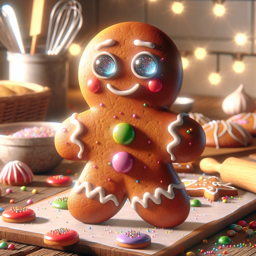

{
    'character_appearence': 'The same playful gingerbread man from the first illustration, running swiftly.',
    'style_attributes': 'Photo-realistic, vibrant countryside scene.',
    'worn_and_carried': 'Keeping his candy buttons and vibrant icing intact as he runs.',
    'scenario': 'A lush meadow with wildflowers, the gingerbread man is being chased by a cow, a sheep, and a 
chicken.'
}

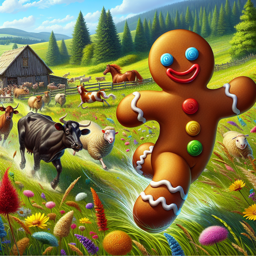

{
    'character_appearence': 'The gingerbread man from the previous illustrations, looking determined yet 
cautious.',
    'style_attributes': 'Photo-realistic, serene river scene with golden sunlight reflection.',
    'worn_and_carried': 'His iconic candy buttons and icing, appearing slightly apprehensive.',
    'scenario': 'Standing at a riverbank with a clever-looking fox nearby, considering how to cross the river.'
}

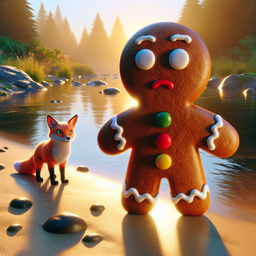

Editor:

The story and illustrations are delightful and engaging. Here are a few suggestions for improvement:               

Story Suggestions:                                                                                                 

 1 Character Development:                                                                                          
    • Add more detail about the gingerbread man’s personality and emotions. How does he feel about leaving the     
      bakery, and what motivates his adventure?                                                                    
 2 Dialogue and Detail:                                                                                            
    • Incorporate more dialogue to bring interactions to life, especially with the fox.                            
    • Paint a vivid picture of the settings with sensory details—what does the gingerbread man see, feel, and hear 
      during his journey?                                                                                          
 3 Ending:                                                                                                         
    • Consider a twist or moral to the story, perhaps highlighting the consequences of trusting strangers or the   
      joys of exploring with caution.                                                                              

Illustration Suggestions:                                                                                          

 1 Consistency and Themes:                                                                                         
    • Ensure visual consistency across illustrations. The gingerbread man’s appearance should remain the same.     
 2 Emotional Expression:                                                                                           
    • Show varying expressions on the gingerbread man to reflect his mood in each scene.                           
 3 Details and Atmosphere:                                                                                         
    • Enhance the background details to make the settings more immersive, focusing on textures and lighting that   
      match the narrative.                                                                                         

Overall, the story and illustrations complement each other well and create a charming tale. Let me know if you’d   
like any specific changes or additional guidance!

Writer:

Title: The Gingerbread Man's Great Adventure                                                                       

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Once upon a time, in a quaint little village, a baker in a cozy kitchen crafted a gingerbread man. The air was     
filled with the sweet aroma of freshly baked cookies, and the little figure on the counter had a mischievous grin  
and sparkling candy eyes.                                                                                          

Suddenly, the gingerbread man twitched and sprang to life. Curious and excited, he hopped down from the tray, eager
to explore the world beyond the bakery doors.                                                                      

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
As he ran through the village, he called out with a joyful voice, "Run, run, as fast as you can. You can't catch   
me, I'm the gingerbread man!" With every step, he felt the thrill of freedom.                                      

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
The gingerbread man's laughter echoed through the fields. A cow, a sheep, and a chicken joined the chase, their    
eyes widening in surprise each time he dashed just out of reach. "Catch me if you can!" he taunted playfully.      

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
With the sun setting, the gingerbread man reached a shimmering river. He paused, pondering his options. The water  
looked cold and treacherous.                                                                                       

Just then, a clever fox appeared, lounging casually by the riverbank. "Need a ride?" he offered smoothly, his eyes 
glinting.                                                                                                          

The gingerbread man hesitated but knew he needed help. Cautiously, he accepted, climbing onto the fox's tail.      

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Midway across, the fox suggested, "Move to my back to stay dry." The gingerbread man obliged. As the river         
deepened, he climbed to the fox's head. Nearing the riverbank, the fox tossed him into the air, catching him in a  
single gulp.                                                                                                       

In that moment, the gingerbread man realized his mistake. His thrilling adventure ended, leaving behind a tale that
would inspire others to explore the world with both courage and caution.

Enter your message, type 'APPROVE' to conclude the task: APPROVE


User:                                                       

APPROVE

In [24]:
runtime.start()
session_id = str(uuid.uuid4())
await runtime.publish_message(
    GroupChatMessage(
        body=UserMessage(
            content="Please write a short story about the gingerbread man with up to 3 photo-realistic illustrations.",
            source="User",
        )
    ),
    TopicId(type=group_chat_topic_type, source=session_id),
)
await runtime.stop_when_idle()
